(0.0, 20.0)

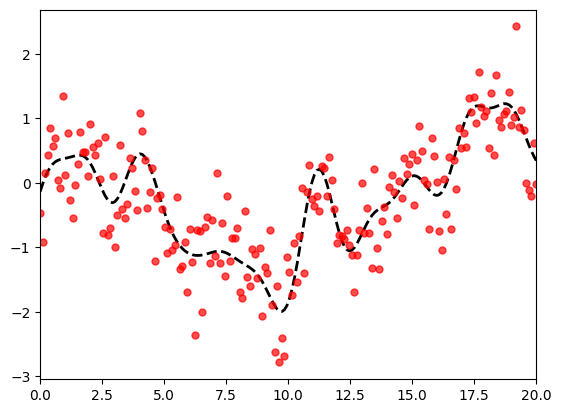

In [40]:
from typing import Optional

import tensorflow as tf
import numpy as np
from check_shapes import check_shapes, inherit_check_shapes
from typing import Optional, Tuple, Type, Union, cast
import tensorflow_probability as tfp
import gpflow

from gpflow.base import InputData, MeanAndVariance, RegressionData, TensorData
from gpflow.kernels import Kernel
from gpflow.likelihoods import Gaussian
from gpflow.mean_functions import MeanFunction
from gpflow.models.model import GPModel
from gpflow.models.training_mixins import InternalDataTrainingLossMixin
from gpflow.models.util import data_input_to_tensor
from gpflow.config import default_float, default_jitter
from gpflow.utilities import to_default_float
from gpflow import posteriors
from gpflow.utilities.ops import eye
import random
import w 

import tensorflow as tf
import numpy as np
import gpflow

import matplotlib.pyplot as plt
tf.keras.config.set_floatx('float64')
seed = 10

#set seed
np.random.seed(seed)
tf.random.set_seed(seed)

#create X
n_points = 200
sigma_n = 0.5
#percentage of points in x which are biased
percent_miss=0.0001


#
lengthscale = 1
variance = 1

variance_out = 2

kernel=gpflow.kernels.SquaredExponential(lengthscales=lengthscale, variance=variance)

x = np.linspace(0, 20, n_points).reshape(n_points, 1)
f = np.random.multivariate_normal(mean=np.zeros(len(x)) ,cov=kernel(x, x)).reshape(n_points, 1)

i_obs = np.random.choice(
    np.arange(0, n_points, 1), int( n_points), replace=False)

y_obs = f[i_obs] + np.random.normal(scale=sigma_n, size=n_points).reshape(n_points, 1)
x_obs = x[i_obs]

arr1inds = x_obs[:,0].argsort()
x_obs = x_obs[arr1inds]
y_obs = y_obs[arr1inds]

i_mis = np.random.choice(
    np.arange(0, n_points, 1), int(percent_miss * n_points), replace=False)

y_mis_pos = y_obs[i_mis[(y_obs[i_mis]>0)[:,0]]]  + np.random.uniform(3, 5, size=len(i_mis[(y_obs[i_mis]>0)[:,0]])).reshape(len(i_mis[(y_obs[i_mis]>0)[:,0]]),1)
y_mis_neg = y_obs[i_mis[(y_obs[i_mis]<=0)[:,0]]]  - np.random.uniform(3, 5, size=len(i_mis[(y_obs[i_mis]<=0)[:,0]])).reshape(len(i_mis[(y_obs[i_mis]<=0)[:,0]]),1)
y_obs[i_mis[(y_obs[i_mis]>0)[:,0]]] = y_mis_pos
y_obs[i_mis[(y_obs[i_mis]<=0)[:,0]]] = y_mis_neg
X=x
y=y_obs

plt.plot(x, f, color='black', ls='--', lw=2)
plt.plot(x_obs, y_obs, 'r.', ms=10, alpha=0.7)
plt.xlim(x[0], x[-1])

In [46]:
variance = tf.Variable(0.4, dtype=tf.float64, constraint=lambda z: tf.clip_by_value(z, 0.001, 10))
lengthscale = tf.Variable(0.4, dtype=tf.float64, constraint=lambda z: tf.clip_by_value(z, 0.001, 10))

alpha=tf.constant(0.1,dtype=tf.float64)
k_11=tf.constant((1-2*alpha)/(alpha*(1-alpha)),dtype=tf.float64)
k_22=tf.constant(2/(alpha*(1-alpha)),dtype=tf.float64)
N = X.shape[0]
mu_alpha_inv=tf.constant([1]*N, dtype=tf.float64)
b_squared=1.

def divide_batch(X, y, test_ratio=0.2, seed=None):
    if seed is None:
        seed = np.random.uniform(0, 1000)

    random.seed(seed)

    # Get the number of samples
    n = tf.shape(X)[0]
    num_test = tf.cast(tf.math.round(test_ratio * tf.cast(n, tf.float32)), tf.int32)

    # Shuffle indices
    indices = tf.range(n)
    shuffled_indices = tf.random.shuffle(indices)

    # Split indices
    test_indices = shuffled_indices[:num_test]
    train_indices = shuffled_indices[num_test:]

    # Split data
    X_train = tf.gather(X, train_indices)
    X_test = tf.gather(X, test_indices)
    Y_train = tf.gather(y, train_indices)
    Y_test = tf.gather(y, test_indices)
    return X_train, Y_train, X_test, Y_test, train_indices, test_indices


def update_mu_alpha_inv(mu_f,sigma_f_diag,y,b_squared):
    diff_1=(4+k_11**2)/b_squared
    diff_2=(tf.squeeze(y-mu_f)**2+sigma_f_diag)/(k_22*b_squared)
    return (diff_1/diff_2)**0.5
    
for i in range(300):
    print(i)
    with tf.GradientTape(persistent=True) as tape:
        #create batch for the iteration
        X_train, Y_train, X_test, Y_test, train_indices, test_indices = divide_batch(X, y, test_ratio=0.2, seed=1)
        n_test = X_test.shape[0]
        
        #estimate Gpflow kernel.
        
        kernel = tfp.math.psd_kernels.ExponentiatedQuadratic(variance, lengthscale)
        K = kernel.matrix(X_train, X_train)
        mu_alpha_inv_t=tf.gather(mu_alpha_inv, train_indices)
        W=tf.linalg.diag(1/mu_alpha_inv_t)*b_squared
        
        
        K_star = tf.transpose(kernel.matrix(X_test, X_train))
        K_star_star = kernel.matrix(X_test, X_test)

        mu_f_pred = tf.transpose(K_star) @ tf.linalg.inv(K+W) @ (Y_train-k_11*1/tf.reshape(mu_alpha_inv_t, (-1, 1)))
        """sigma_f_pred=K_star_star-tf.transpose(K_star) @tf.linalg.inv(K+W)@K_star
        vv = tfp.distributions.MultivariateNormalFullCovariance(mu_f_pred, sigma_f_pred)
        loss = vv.log_prob(tf.squeeze(Y_test))
        """
        loss=tf.reduce_sum(abs(Y_test-mu_f_pred))
    grad = tape.gradient(loss, [ variance, lengthscale])
    print( [variance, lengthscale])
    optimizer = tf.optimizers.Adam()
    optimizer.apply_gradients(zip(grad, [ variance, lengthscale,]))
    #update alpha
    K = kernel.matrix(X, X)
    W=(b_squared)/tf.linalg.diag(1/mu_alpha_inv)
    K_plus_W_inv=tf.linalg.inv(K+W)
    mu_f=K@K_plus_W_inv@(y-k_11*1/tf.reshape(mu_alpha_inv, (-1, 1)))
    Sigma_f=tf.linalg.inv(K+W)
    b_squared=tf.reduce_mean((tf.squeeze(y-mu_f)**2+tf.linalg.diag_part(Sigma_f))*mu_alpha_inv)
    mu_alpha_inv=update_mu_alpha_inv(mu_f,tf.linalg.diag_part(Sigma_f),y,b_squared)

    
K = kernel.matrix(X, X)   
W=b_squared/tf.linalg.diag(1/mu_alpha_inv)
K_plus_W_inv=tf.linalg.inv(K+W)


0
[<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=0.4>, <tf.Variable 'Variable:0' shape=() dtype=float64, numpy=0.4>]
1


2025-04-03 20:14:06.712516: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: INVALID_ARGUMENT: Input is not invertible.


InvalidArgumentError: {{function_node __wrapped__MatrixInverse_device_/job:localhost/replica:0/task:0/device:CPU:0}} Input is not invertible. [Op:MatrixInverse] name: 

In [45]:
b_squared

<tf.Tensor: shape=(), dtype=float64, numpy=nan>

UniqueWithCounts(y=<tf.Tensor: shape=(2,), dtype=bool, numpy=array([False,  True])>, idx=<tf.Tensor: shape=(200,), dtype=int32, numpy=
array([0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0,
       0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1,
       1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0,
       1, 0], dtype=int32)>, count=<tf.Tensor: shape=(2,), dtype=int32, numpy=array([118,  82], dtype=int32)>)

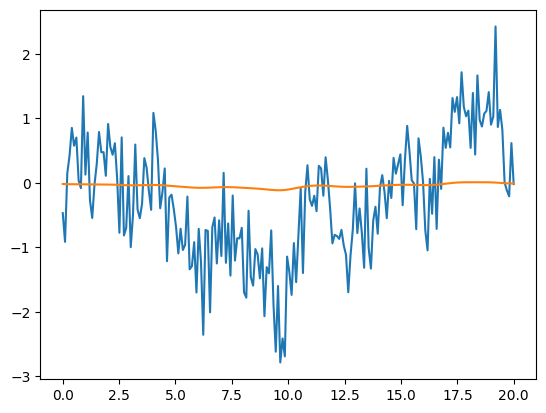

In [36]:
pred_lap_absloss=K@K_plus_W_inv@(y-k_11*1/tf.reshape(mu_alpha_inv, (-1, 1)))
plt.plot(X,y)
plt.plot(X,pred_lap_absloss)
tf.unique_with_counts(tf.reshape(y>pred_lap_absloss,-1))


In [77]:
variance = tf.Variable(0.4, dtype=tf.float64, constraint=lambda z: tf.clip_by_value(z, 0.001, 10))
lengthscale = tf.Variable(0.4, dtype=tf.float64, constraint=lambda z: tf.clip_by_value(z, 0.001, 10))

alpha=tf.constant(0.1,dtype=tf.float64)
k_11=tf.constant((1-2*alpha)/(alpha*(1-alpha)),dtype=tf.float64)
k_22=tf.constant(2/(alpha*(1-alpha)),dtype=tf.float64)
N = X.shape[0]
mu_alpha_inv=tf.constant([1]*N, dtype=tf.float64)
b_squared=1.

def divide_batch(X, y, test_ratio=0.2, seed=None):
    if seed is None:
        seed = np.random.uniform(0, 1000)

    random.seed(seed)

    # Get the number of samples
    n = tf.shape(X)[0]
    num_test = tf.cast(tf.math.round(test_ratio * tf.cast(n, tf.float32)), tf.int32)

    # Shuffle indices
    indices = tf.range(n)
    shuffled_indices = tf.random.shuffle(indices)

    # Split indices
    test_indices = shuffled_indices[:num_test]
    train_indices = shuffled_indices[num_test:]

    # Split data
    X_train = tf.gather(X, train_indices)
    X_test = tf.gather(X, test_indices)
    Y_train = tf.gather(y, train_indices)
    Y_test = tf.gather(y, test_indices)
    return X_train, Y_train, X_test, Y_test, train_indices, test_indices


def update_mu_alpha_inv(mu_f,sigma_f_diag,y,b_squared):
    diff_1=(4+k_11**2)/b_squared
    diff_2=(tf.squeeze(y-mu_f)**2+sigma_f_diag)/(b_squared)
    return (diff_1/diff_2)**0.5
    
for i in range(300):
    print(i)
    with tf.GradientTape(persistent=True) as tape:
        #create batch for the iteration
        
        #estimate Gpflow kernel.
        
        kernel = tfp.math.psd_kernels.ExponentiatedQuadratic(variance, lengthscale)
        K = kernel.matrix(X, X)
        W=tf.linalg.diag(1/mu_alpha_inv)*b_squared
        
        vv = tfp.distributions.MultivariateNormalFullCovariance(tf.zeros_like(mu_alpha_inv),tf.linalg.inv(K+W))
        loss = vv.log_prob(tf.squeeze((y-k_11*1/tf.reshape(mu_alpha_inv, (-1, 1)))))
    grad = tape.gradient(loss, [ variance, lengthscale])
    print( [variance, lengthscale])
    optimizer = tf.optimizers.Adam()
    optimizer.apply_gradients(zip(grad, [ variance, lengthscale,]))
    #update alpha
    K = kernel.matrix(X, X)
    W=tf.linalg.diag(1/mu_alpha_inv)*b_squared
    K_plus_W_inv=tf.linalg.inv(K+W)
    mu_f=K@K_plus_W_inv@y
    Sigma_f=tf.linalg.inv(K+W)
    b_squared=tf.reduce_mean((tf.squeeze(y-mu_f)**2+tf.linalg.diag_part(Sigma_f))*mu_alpha_inv)+tf.reduce_mean((k_11**2+4)/(mu_alpha_inv))
    mu_alpha_inv=update_mu_alpha_inv(mu_f,tf.linalg.diag_part(Sigma_f),y,b_squared)
K = kernel.matrix(X, X)   
W=tf.linalg.diag(1/mu_alpha_inv)*b_squared
K_plus_W_inv=tf.linalg.inv(K+W)


0
[<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=0.4>, <tf.Variable 'Variable:0' shape=() dtype=float64, numpy=0.4>]
1
[<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=0.40099999332421304>, <tf.Variable 'Variable:0' shape=() dtype=float64, numpy=0.40099999332416403>]
2
[<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=0.40199998664684494>, <tf.Variable 'Variable:0' shape=() dtype=float64, numpy=0.40199998664501996>]
3
[<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=0.40299997996910586>, <tf.Variable 'Variable:0' shape=() dtype=float64, numpy=0.4029999799650575>]
4
[<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=0.4039999732917912>, <tf.Variable 'Variable:0' shape=() dtype=float64, numpy=0.4039999732860438>]
5
[<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=0.4049999666140816>, <tf.Variable 'Variable:0' shape=() dtype=float64, numpy=0.40499996660617327>]
6
[<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=0.4059999599366426>, <t

In [78]:
pred_lap_absloss=K@K_plus_W_inv@(y-k_11*1/tf.reshape(mu_alpha_inv, (-1, 1)))
pred_lap_absloss

<tf.Tensor: shape=(200, 1), dtype=float64, numpy=
array([[-0.51103213],
       [-0.52208497],
       [-0.52781839],
       [-0.52917201],
       [-0.52721137],
       [-0.52294875],
       [-0.51718781],
       [-0.51042393],
       [-0.50282226],
       [-0.49428089],
       [-0.48456896],
       [-0.47351368],
       [-0.46119825],
       [-0.44812829],
       [-0.43532776],
       [-0.42433676],
       [-0.41710084],
       [-0.41576092],
       [-0.42237147],
       [-0.43858886],
       [-0.46537848],
       [-0.50278831],
       [-0.54982717],
       [-0.60447062],
       [-0.6637989 ],
       [-0.72425186],
       [-0.78196964],
       [-0.83317697],
       [-0.87456381],
       [-0.9036177 ],
       [-0.91887074],
       [-0.92003654],
       [-0.90802684],
       [-0.88485175],
       [-0.85342017],
       [-0.81726647],
       [-0.78023523],
       [-0.74615741],
       [-0.71854954],
       [-0.70036248],
       [-0.69379895],
       [-0.70021069],
       [-0.72007674],
    

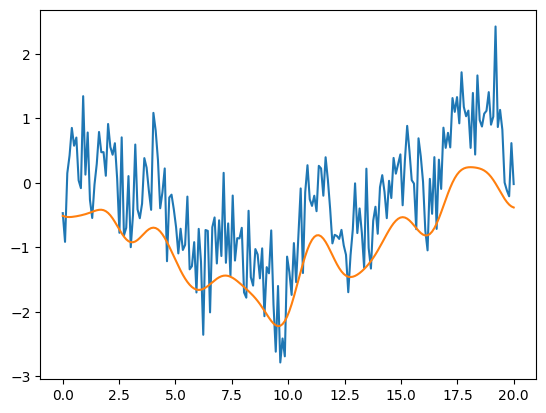

In [79]:
plt.plot(X,y)
plt.plot(X,pred_lap_absloss)

In [82]:
tf.unique_with_counts(tf.reshape(y>pred_lap_absloss,-1))


UniqueWithCounts(y=<tf.Tensor: shape=(2,), dtype=bool, numpy=array([ True, False])>, idx=<tf.Tensor: shape=(200,), dtype=int32, numpy=
array([0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0,
       0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0], dtype=int32)>, count=<tf.Tensor: shape=(2,), dtype=int32, numpy=array([179,  21], dtype=int32)>)